In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

pd.set_option('display.max_columns', None)

In [42]:
train_data = pd.read_csv('train_data.csv')
train_data = train_data.infer_objects()

val_data = pd.read_csv('val_data.csv')
val_data = val_data.infer_objects()

In [43]:
# Filtering columns for model deployment

# train_data_filtered = train_data.drop(labels=['is_canceled','adr','reservation_status','reservation_status_date','hotel',
#     'assigned_room_type','lead_time'],axis=1)
# val_data_filtered = val_data.drop(labels=['is_canceled','adr','reservation_status','reservation_status_date','hotel',
#     'assigned_room_type','lead_time'],axis=1)

In [44]:
train_data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,City Hotel,0,17,2015,October,40,1,0,3,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Contract,113.33,0,2,Check-Out,2015-10-04
1,City Hotel,1,99,2016,July,30,21,0,1,2,1.0,0,BB,ESP,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,130.50,0,0,Canceled,2016-06-09
2,City Hotel,1,156,2017,May,19,12,1,2,1,0.0,0,BB,USA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,130.80,0,0,Canceled,2016-12-07
3,City Hotel,1,129,2017,June,22,2,1,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,154.0,NaN,0,Transient,130.00,0,0,Canceled,2017-01-24
4,City Hotel,1,21,2015,October,44,31,2,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,1,0,A,A,0,No Deposit,9.0,NaN,0,Contract,105.79,0,0,Canceled,2015-10-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55481,City Hotel,0,215,2017,August,34,25,0,1,2,3.0,0,BB,GBR,Direct,Direct,0,0,0,G,G,0,No Deposit,14.0,NaN,0,Transient,245.00,0,1,Check-Out,2017-08-26
55482,City Hotel,1,229,2017,July,28,12,1,4,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,NaN,NaN,0,Transient,110.00,0,0,Canceled,2016-11-25
55483,City Hotel,0,0,2016,January,4,19,0,1,1,0.0,0,BB,PRT,Corporate,Corporate,0,0,0,A,A,0,No Deposit,180.0,NaN,0,Transient,66.00,1,0,Check-Out,2016-01-20
55484,City Hotel,0,53,2015,August,35,24,1,1,2,0.0,0,BB,ESP,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1.0,NaN,0,Transient-Party,62.00,0,0,Check-Out,2015-08-26


In [45]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55486 entries, 0 to 55485
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           55486 non-null  object 
 1   is_canceled                     55486 non-null  int64  
 2   lead_time                       55486 non-null  int64  
 3   arrival_date_year               55486 non-null  int64  
 4   arrival_date_month              55486 non-null  object 
 5   arrival_date_week_number        55486 non-null  int64  
 6   arrival_date_day_of_month       55486 non-null  int64  
 7   stays_in_weekend_nights         55486 non-null  int64  
 8   stays_in_week_nights            55486 non-null  int64  
 9   adults                          55486 non-null  int64  
 10  children                        55484 non-null  float64
 11  babies                          55486 non-null  int64  
 12  meal                            

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin
import math

class FeatureExtractor(TransformerMixin):
    def  __init__(self):
        print('Feature Extractor initiated...')

    def fit(self,X,y=None):
        print('Fitting data...')
        return self

    def transform(self, X, y=None, add_time_series=True):
        print('Extracting data...')
        X_ = X.copy()

        X_.rename(columns={'arrival_date_year':'arrival_year', 'arrival_date_month':'arrival_month', 'arrival_date_day_of_month':'arrival_day_of_month', 'arrival_date_week_number':'arrival_week_number'}, inplace=True)
        X_['arrival_month'] = X_.apply(lambda x: self.__get_month_index(x['arrival_month']), axis=1)
        X_['arrival_date'] = X_.apply(lambda x: self.__get_date(x['arrival_year'], x['arrival_month'], x['arrival_day_of_month']), axis=1)
        X_['arrival_date'] = pd.to_datetime(X_['arrival_date'], format='%Y-%m-%d')
        X_['arrival_year'] = X_['arrival_date'].dt.year
        X_['arrival_month'] = X_['arrival_date'].dt.month
        X_['arrival_day_of_month'] = X_['arrival_date'].dt.day
        X_['arrival_day_of_week'] = X_['arrival_date'].dt.day_of_week
        X_['arrival_week_number'] = X_['arrival_date'].dt.isocalendar().week
        # X_['reservation_status_date'] = pd.to_datetime(X_['reservation_status_date'], format='%Y-%m-%d')
        
        X_ = self.__null_handler(X_)

        X_['children'] = X_['children'].apply(int)
        X_['agent'] = X_['agent'].apply(int)
        X_['company'] = X_['company'].apply(int)

        X_['booking_date'] = X_.apply(lambda x: x['arrival_date'] - timedelta(days=x['lead_time']), axis=1)
        X_['booking_date'] = pd.to_datetime(X_['booking_date'], format='%Y-%m-%d')
        X_['booking_year'] = X_['booking_date'].dt.year
        X_['booking_month'] = X_['booking_date'].dt.month
        X_['booking_day_of_month'] = X_['booking_date'].dt.day
        X_['booking_day_of_week'] = X_['booking_date'].dt.day_of_week
        X_['booking_week_number'] = X_['booking_date'].dt.isocalendar().week

        X_['is_family'] = X_.apply(lambda x: self.__family(x['children'] + x['babies']), axis=1)

        timeseries_labels = ['arrival_month','arrival_week_number','arrival_day_of_month','arrival_day_of_week',
                'booking_month', 'booking_week_number', 'booking_day_of_month', 'booking_day_of_week']

        if add_time_series:
            for label in timeseries_labels:
                X_[label + "_norm"] = 2 * math.pi * X_[label] / X_[label].max()
                X_["cos_" + label] = np.cos(X_[label + "_norm"])
                X_["sin_" + label] = np.sin(X_[label + "_norm"])

                X_.drop(labels=[label + '_norm', label], axis=1, inplace=True)

        X_.drop(labels=['is_canceled','adr','reservation_status','reservation_status_date','hotel','assigned_room_type','lead_time'],axis=1,inplace=True)
        X_.drop(labels=['arrival_date','arrival_year','booking_date','booking_year'],axis=1,inplace=True)

        # self.__view_data_specs(X_)
        return X_

    def __null_handler(self,X):
        X.agent.fillna(0, inplace=True)
        X.company.fillna(0, inplace=True)
        X.children.fillna(0, inplace=True)
        X.country.fillna('PRT', inplace=True)
        X.loc[X[X['market_segment'] == 'Undefined'].index, 'market_segment'] = 'Online TA'
        X.loc[X[X['distribution_channel'] == 'Undefined'].index, 'distribution_channel'] = 'TA/TO'
        return X

    def __get_month_index(self,month):
        months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        return months.index(month)+1

    def __get_date(self,year,month,day):
        return str(year) + '-' + str(month) + '-' + str(day)

    def __family(self,value):
        if value > 0:
            return 1
        else:
            return 0

    def __view_data_specs(self,data):
        print(data.columns)
        print(data.shape)
        print(data.info())

# feature_extractor = FeatureExtractor()
# transformed_data = feature_extractor.fit_transform(train_data)
# transformed_data.info()

In [47]:
transformed_data.columns

Index(['stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'deposit_type', 'agent', 'company',
       'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'is_family', 'cos_arrival_month',
       'sin_arrival_month', 'cos_arrival_week_number',
       'sin_arrival_week_number', 'cos_arrival_day_of_month',
       'sin_arrival_day_of_month', 'cos_arrival_day_of_week',
       'sin_arrival_day_of_week', 'cos_booking_month', 'sin_booking_month',
       'cos_booking_week_number', 'sin_booking_week_number',
       'cos_booking_day_of_month', 'sin_booking_day_of_month',
       'cos_booking_day_of_week', 'sin_booking_day_of_week'],
      dtype='object')

In [48]:
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(3,3))
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)

In [49]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,confusion_matrix,f1_score,accuracy_score

def test_model_1(model):
    model.fit(X_train_1,y_train_1)
    y_train_pred_1 = model.predict(X_train_1)
    y_val_pred_1 = model.predict(X_val_1)

    print('- Train score:', model.score(X_train_1,y_train_1))
    print('- F1 score (train):', f1_score(y_train_1, y_train_pred_1))

    print('- Val score:', model.score(X_val_1,y_val_1))
    print('- F1 score (val):', f1_score(y_val_1, y_val_pred_1))
    conf_matrix(y_val_1,y_val_pred_1)

    # test_data = pd.read_csv('test_data.csv')
    # X_test, y_test = test_data, test_data['is_canceled']
    # y_test_pred = model.predict(X_test)
    # print('- Test score:', {model.score(X_test,y_test)})
    # print('- F1 score (test):', f1_score(y_test, y_test_pred))

In [80]:
import pickle
from pathlib import Path
import os

def create_pkl(model, filename):
    os.getcwd()
    current_directory = Path(os.getcwd()).parent
    pkl_file = os.path.join(current_directory, 'pickle_files', filename + '.pkl')
    pickle_out = open(pkl_file,'wb')
    pickle.dump(model,pickle_out)
    pickle_out.close()
    print('Pickle file saved')

### Model 1 - Predicting cancellations

In [51]:
X_train_1, y_train_1 = train_data, train_data['is_canceled']
X_val_1, y_val_1 = val_data, val_data['is_canceled']

In [52]:
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import make_column_transformer,make_column_selector,ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA,TruncatedSVD

columnTransformer_1 = ColumnTransformer([
    ('cat_transformer', OneHotEncoder(sparse=True), make_column_selector(dtype_include=object)),
    ('num_transformer', StandardScaler(), make_column_selector(dtype_exclude=object))
], remainder='passthrough')

full_transformer_1 = Pipeline([
    ('feature_extractor', FeatureExtractor()),
    ('col_transformer', columnTransformer_1),
    ('pca', TruncatedSVD(n_components=50)),
])

# full_transformer_1.fit(train_data)
# transformed_data = full_transformer_1.transform(train_data)

Feature Extractor initiated...


In [24]:
# np.cumsum(full_transformer_1['pca'].explained_variance_ratio_)

Fitting data...
Extracting data...


/home/vikram/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Extracting data...
Extracting data...
Extracting data...
- Train score: 0.8005442814403634
- F1 score (train): 0.7549651278644968
Extracting data...
- Val score: 0.8041172409464633
- F1 score (val): 0.7577427617790887


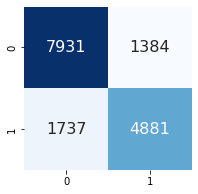

In [25]:
from sklearn.linear_model import LogisticRegression

model_1_logreg = Pipeline([
    ('full_transformer', full_transformer_1),
    ('log_reg', LogisticRegression(class_weight='balanced', n_jobs=-1))
])

test_model_1(model_1_logreg)

Fitting data...
Extracting data...
Extracting data...
Extracting data...
Extracting data...
- Train score: 0.9940525537973542
- F1 score (train): 0.992874109263658
Extracting data...
- Val score: 0.866691771794389
- F1 score (val): 0.8240848103362598


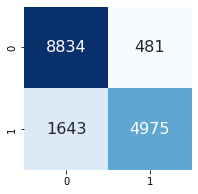

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostRegressor,GradientBoostingRegressor

model_1_rf = Pipeline([
    ('full_transformer', full_transformer_1),
    ('forest_reg', RandomForestClassifier(class_weight='balanced', n_jobs=-1))
])

test_model_1(model_1_rf)

Fitting data...
Extracting data...
Extracting data...
Extracting data...
Extracting data...
- Train score: 0.8517824316043686
- F1 score (train): 0.8198782250646108
Extracting data...
- Val score: 0.8452268875917907
- F1 score (val): 0.809369202226345


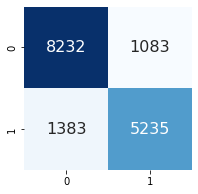

In [53]:
from sklearn.svm import SVC

model_1_svc = Pipeline([
    ('full_transformer', full_transformer_1),
    ('svc', SVC(class_weight='balanced'))
])

test_model_1(model_1_svc)

Although SVC has lesser F1 score compared to RandomForest classifier, it is selected as RandomForest classifier has overfitted to training data. SVC predictions can be finetuned by hyperparameter tuning.

In [ ]:
# Pickle File Creation

model_pipeline = Pipeline([
    ('col_transformer', columnTransformer_1),
    ('pca', TruncatedSVD(n_components=50)),
    ('svc', SVC(class_weight='balanced'))
])

feature_ex = FeatureExtractor()
feature_ex.fit(X_train_1,y_train_1)

X_train_transformed_1 = feature_ex.transform(X_train_1)
X_val_transformed_1 = feature_ex.transform(X_val_1)

model_pipeline.fit(X_train_transformed_1,y_train_1)
y_val_pred_1 = model_pipeline.predict(X_val_transformed_1)

print('- Val score:', model_pipeline.score(X_val_transformed_1,y_val_1))
print('- F1 score (val):', f1_score(y_val_1, y_val_pred_1))
conf_matrix(y_val_1,y_val_pred_1)

create_pkl(model_pipeline, "model_1_svc")

### Model 2 - Lead Time Prediction

In [82]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,confusion_matrix,f1_score,accuracy_score

def test_model_2(model):
    model.fit(X_train_2,y_train_2)
    y_train_pred_2 = model.predict(X_train_2)
    y_val_pred_2 = model.predict(X_val_2)

    print('- Train score:', model.score(X_train_2,y_train_2))
    print('- RMSE (train):', np.sqrt(mean_squared_error(y_train_2,y_train_pred_2)))
    print('- MAPE (train):', np.sqrt(mean_absolute_percentage_error(y_train_2,y_train_pred_2)))
    
    print('- Val score:', model.score(X_val_2,y_val_2))
    print('- RMSE (val):', np.sqrt(mean_squared_error(y_val_2,y_val_pred_2)))
    print('- MAPE (val):', np.sqrt(mean_absolute_percentage_error(y_val_2,y_val_pred_2)))

    # test_data = pd.read_csv('test_data.csv')
    # X_test, y_test = test_data, get_cancel_lead_time(test_data)
    # y_test_pred = model.predict(X_test)
    # print('- Test score:', {model.score(X_test,y_test)})
    # print('- F1 score (test):', f1_score(y_test, y_test_pred))

In [83]:
# Creating y values (Cancel Lead Time)

def get_cancel_lead_time(data):
    duplicate = data.copy()
    duplicate.rename(columns={'arrival_date_year':'arrival_year', 'arrival_date_month':'arrival_month', 'arrival_date_day_of_month':'arrival_day_of_month', 'arrival_date_week_number':'arrival_week_number'}, inplace=True)
    duplicate['reservation_status_date'] = pd.to_datetime(duplicate['reservation_status_date'], format='%Y-%m-%d')
    duplicate['arrival_month'] = duplicate.apply(lambda x: __get_month_index(x['arrival_month']), axis=1)
    duplicate['arrival_date'] = duplicate.apply(lambda x: __get_date(x['arrival_year'], x['arrival_month'], x['arrival_day_of_month']), axis=1)
    duplicate['arrival_date'] = pd.to_datetime(duplicate['arrival_date'], format='%Y-%m-%d')
    duplicate['cancel_lead_time'] = (duplicate['arrival_date'] - duplicate['reservation_status_date']).dt.days
    duplicate.loc[duplicate['cancel_lead_time'] < 0, 'cancel_lead_time'] = 0
    return duplicate['cancel_lead_time']

def __get_date(year,month,day):
    return str(year) + '-' + str(month) + '-' + str(day)

def __get_month_index(month):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    return months.index(month)+1

In [87]:
X_train_2,y_train_2 = train_data,get_cancel_lead_time(train_data)
X_val_2,y_val_2 = val_data,get_cancel_lead_time(val_data)

In [88]:
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import make_column_transformer,make_column_selector,ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA,TruncatedSVD

columnTransformer_2 = ColumnTransformer([
    ('cat_transformer', OneHotEncoder(), make_column_selector(dtype_include=object)),
    ('num_transformer', StandardScaler(), make_column_selector(dtype_include=int))
], remainder='passthrough')

full_transformer_2 = Pipeline([
    ('feature_extractor', FeatureExtractor()),
    ('col_transformer', columnTransformer_2),
    # ('pca', TruncatedSVD(n_components=30)),
])

# full_transformer.fit(train_data)
# transformed_data = full_transformer.transform(train_data)

Feature Extractor initiated...


### RandomForest

With 90% Accuracy 

pickle created - final_model.pkl

In [89]:
from sklearn.ensemble import RandomForestRegressor,ExtraTreesClassifier,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier

model_2_rf = Pipeline([
    ('full_transformer', full_transformer_2),
    ('forest_reg', RandomForestRegressor(n_estimators=200,n_jobs=-1))
])

test_model_2(model_2_rf)

Fitting data...
Extracting data...
Extracting data...
Extracting data...
Extracting data...
- Train score: 0.9827818022988681
- RMSE (train): 9.861554776941498
- MAPE (train): 88812797.74120754
Extracting data...
- Val score: 0.8910888686574805
- RMSE (val): 24.784509654515492
- MAPE (val): 141023134.29479343


In [42]:
from sklearn.svm import SVR

model_2_svr = Pipeline([
    ('full_transformer', full_transformer_2),
    ('svr', SVR())
])

test_model_2(model_2_svr)

Fitting data...
Extracting data...
Extracting data...
Extracting data...
Extracting data...
- Train score: 0.6039217137962252
- RMSE (train): 47.297922291248206
- MAPE (train): 103227222.65117216
Extracting data...
- Val score: 0.6147457235108373
- RMSE (val): 46.61416729870745
- MAPE (train): 101441405.25843261


RandomForestRegressor is selected here as SVR does not perform well. RandomForest regressor can be finetuned by hyperparameter tuning.

In [90]:
# Final Pickle Creation

model_pipeline = Pipeline([
    ('full_transformer', columnTransformer_2),
    ('forest_reg', RandomForestRegressor(n_estimators=200,n_jobs=-1))
])

feature_ex = FeatureExtractor()
feature_ex.fit(X_train_2,y_train_2)

X_train_transformed_2 = feature_ex.transform(X_train_2)
X_val_transformed_2 = feature_ex.transform(X_val_2)

model_pipeline.fit(X_train_transformed_2,y_train_2)
y_val_pred_2 = model_pipeline.predict(X_val_transformed_2)

print('- Val score:', model_pipeline.score(X_val_transformed_2,y_val_2))
print('- RMSE (val):', np.sqrt(mean_squared_error(y_val_2,y_val_pred_2)))
print('- MAPE (val):', np.sqrt(mean_absolute_percentage_error(y_val_2,y_val_pred_2)))

create_pkl(model_pipeline, "model_2_rf")

Feature Extractor initiated...
Fitting data...
Extracting data...
Extracting data...
- Val score: 0.8913322404536728
- RMSE (val): 24.75680255053345
- MAPE (val): 140960646.86221611
Pickle file saved


### Only KMeans
85% Accuracy

Needs dimensionality reduction & Outlier elimination

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,ExtraTreesClassifier,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.cluster import KMeans

model_pipeline_2 = Pipeline([
    ('full_transformer', full_transformer),
    ('kmeans', KMeans()),
    ('forest_reg', RandomForestRegressor(n_estimators=200,n_jobs=-1))
])

model_pipeline_2
test_model(model_pipeline_2)

Fitting data...
Extracting data...
Extracting data...
Extracting data...
-Train score: 0.9767997400762126
Extracting data...
-Val score: 0.8490413952524607
Extracting data...
-Test score: 0.847905761402395


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(5,30))
grid_reg = GridSearchCV(model_pipeline_2, param_grid, cv=3, verbose=2)
grid_reg.fit(X_train,y_train)

In [18]:
grid_reg.cv_results_

{'mean_fit_time': array([ 6.29706645,  7.01004608,  7.94932501,  9.33605536,  9.98911484,
        10.56633393, 11.40360165, 12.72398973, 13.82118789, 15.25095661,
        16.12027073, 17.35291131, 18.56564116, 19.43427793, 20.25435583,
        22.22552292, 23.65226881, 23.9670399 , 24.99051499, 27.22242347,
        27.58068927, 28.41448601, 29.85953021, 31.32906485, 33.31172013]),
 'std_fit_time': array([0.30487176, 0.06555618, 0.11941891, 0.40494874, 0.38194668,
        0.21262757, 0.19487121, 0.31922822, 0.33325863, 0.29866431,
        0.57923295, 0.05992358, 0.51712059, 0.38469092, 0.16232149,
        0.45688405, 0.33699869, 0.34233357, 0.35459041, 0.75606311,
        0.67689689, 0.30430569, 1.13452941, 0.66050329, 1.07354413]),
 'mean_score_time': array([0.95380942, 0.93328913, 0.90576839, 0.9416515 , 0.97041345,
        0.92142542, 0.96610538, 0.94003503, 0.94882417, 0.94676503,
        0.91274166, 0.94996373, 0.94043167, 0.94402933, 0.94125064,
        0.94471049, 0.93732452, 0.9

In [14]:
grid_reg.best_params_

{'kmeans__n_clusters': 5}

In [15]:
grid_reg.score(X_val,y_val)

Extracting data...


0.8312649718319768

### KMeans with PCA

74% Accuracy with TruncatedSVD

In [2]:
# PCA with KMeans

from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor,ExtraTreesClassifier,AdaBoostRegressor,GradientBoostingRegressor

full_transformer.fit(X_train,y_train)
X_train_transformed = full_transformer.transform(X_train)
X_val_transformed = full_transformer.transform(X_val)

model_pipeline_pca = Pipeline([
    ('pca', TruncatedSVD(n_components=50)),
    ('kmeans', KMeans()),
    ('forest_reg', RandomForestRegressor(n_estimators=200,n_jobs=10))
])

model_pipeline_pca.fit(X_train_transformed,y_train)
y_pred = model_pipeline_pca.predict(X_val_transformed)

print(f'-Train score: {model_pipeline_pca.score(X_train_transformed,y_train)}')
print(f'-Val score: {model_pipeline_pca.score(X_val_transformed,y_val)}')


# test_model(model_pipeline_pca)

NameError: name 'full_transformer' is not defined

In [14]:
from sklearn.decomposition import PCA,TruncatedSVD

svd = TruncatedSVD()

svd.fit(X_train_transformed)

TruncatedSVD()

In [16]:
trans = svd.fit_transform(X_train_transformed)
X_train_transformed.shape, trans.shape 

(55486, 2)

In [17]:
trans

array([[ 2.11084818,  2.07338378],
       [ 2.56847194, -1.09083379],
       [ 2.79927329, -0.52270624],
       ...,
       [ 2.00360391, -0.24018114],
       [ 1.94718158,  2.2946249 ],
       [ 0.95843106, -0.86976872]])